In [278]:
import numpy as np
from sklearn import preprocessing
from keras import utils
import numpy.matlib

SD = np.loadtxt('test_datas\sd_test.txt', dtype=float, delimiter=" ")
SM = np.loadtxt('test_datas\sm_test.txt', dtype=float, delimiter=" ")
A = np.loadtxt('test_datas\interaction_test.txt', dtype=int, delimiter=" ")
interacation = np.transpose(A)
from tensorflow.keras.utils import to_categorical

A.size


<>:6: SyntaxWarning: invalid escape sequence '\s'
<>:7: SyntaxWarning: invalid escape sequence '\s'
<>:8: SyntaxWarning: invalid escape sequence '\i'
<>:6: SyntaxWarning: invalid escape sequence '\s'
<>:7: SyntaxWarning: invalid escape sequence '\s'
<>:8: SyntaxWarning: invalid escape sequence '\i'
C:\Users\shahe\AppData\Local\Temp\ipykernel_25800\3681171461.py:6: SyntaxWarning: invalid escape sequence '\s'
  SD = np.loadtxt('test_datas\sd_test.txt', dtype=float, delimiter=" ")
C:\Users\shahe\AppData\Local\Temp\ipykernel_25800\3681171461.py:7: SyntaxWarning: invalid escape sequence '\s'
  SM = np.loadtxt('test_datas\sm_test.txt', dtype=float, delimiter=" ")
C:\Users\shahe\AppData\Local\Temp\ipykernel_25800\3681171461.py:8: SyntaxWarning: invalid escape sequence '\i'
  A = np.loadtxt('test_datas\interaction_test.txt', dtype=int, delimiter=" ")


3100

In [ ]:
R_B = np.matlib.repmat(interacation, 62, 1)
sm = np.repeat(SM, repeats=50, axis=0)
train_m = np.concatenate((sm, R_B), axis=1)  # (189585,990)

R_A = np.repeat(A, repeats=50, axis=0)
sd = np.matlib.repmat(SD, 62, 1)
train_s = np.concatenate((R_A, sd), axis=1)  # (189585,766)
label = A.reshape((3100, 1))

In [280]:
encoder = preprocessing.LabelEncoder()
encoder.fit(label)

# Transform the labels to integer values
ys = encoder.transform(label).astype(np.int32)

# Convert to categorical (one-hot encoding) if needed
ys = to_categorical(ys)

nm = np.arange(len(ys))
ys = ys[nm]


c:\Users\shahe\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\shahe\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Confusion Matrix:
[[288  31]
 [ 30 271]]

Average Accuracy (Acc): 0.8900
Average Sensitivity (Sen): 0.8883
Average Specificity (Spe): 0.8904
Average Precision (Pre): 0.8914
Average Matthews Correlation Coefficient (Mcc): 0.7800
ROC-AUC Score: 0.9379


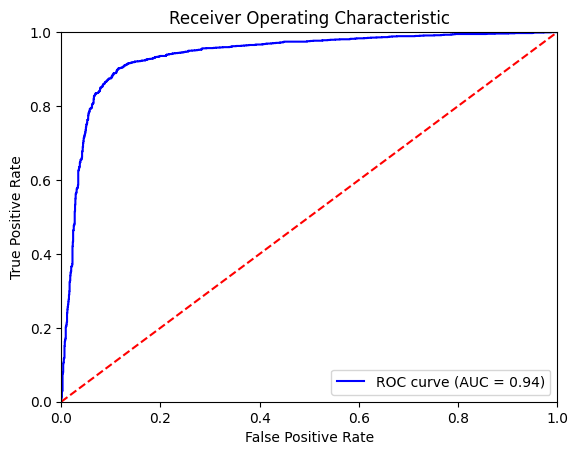

In [281]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score, confusion_matrix, matthews_corrcoef
import matplotlib.pyplot as plt

X = np.hstack((train_m, train_s))
y = ys.flatten()

# Initialize lists to store evaluation metrics
accuracy_results, sensitivity_results, specificity_results, precision_results, mcc_results = [], [], [], [], []
y_true, y_scores = [], []
confusion_matrices = []

# Define KFold cross-validation (5-fold or 10-fold)
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # Use n_splits=10 for 10-fold CV

# Cross-validation loop
for train_index, val_index in kf.split(X):
    x_train, x_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Initialize RandomForestClassifier with class weights to handle imbalance
    clf = RandomForestClassifier(n_estimators=300, max_depth=20,min_samples_split=5,min_samples_leaf=3,random_state=42,class_weight="balanced")
    clf.fit(x_train, y_train)

    # Get predictions and probabilities for evaluation
    y_pred = clf.predict(x_val)
    y_pred_proba = clf.predict_proba(x_val)[:, 1]  # Probabilities for the positive class

    # Store true labels and predicted probabilities for ROC-AUC calculation
    y_true.extend(y_val)
    y_scores.extend(y_pred_proba)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)  # Sensitivity
    mcc = matthews_corrcoef(y_val, y_pred)
    
    # Calculate specificity using the confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    # Append each fold's metrics to results lists
    accuracy_results.append(accuracy)
    sensitivity_results.append(recall)  # Sensitivity
    specificity_results.append(specificity)
    precision_results.append(precision)
    mcc_results.append(mcc)
    
    # Calculate confusion matrix for the fold and store it
    cm = confusion_matrix(y_val, y_pred)
    confusion_matrices.append(cm)


# Calculate average metrics across all folds
avg_accuracy = sum(accuracy_results) / len(accuracy_results)
avg_sensitivity = sum(sensitivity_results) / len(sensitivity_results)
avg_specificity = sum(specificity_results) / len(specificity_results)
avg_precision = sum(precision_results) / len(precision_results)
avg_mcc = sum(mcc_results) / len(mcc_results)
roc_auc = roc_auc_score(y_true, y_scores)  # Overall ROC-AUC score

final_cm = confusion_matrices[-1]
print(f"Confusion Matrix:\n{final_cm}\n")

# Display results
print(f"Average Accuracy (Acc): {avg_accuracy:.4f}")
print(f"Average Sensitivity (Sen): {avg_sensitivity:.4f}")
print(f"Average Specificity (Spe): {avg_specificity:.4f}")
print(f"Average Precision (Pre): {avg_precision:.4f}")
print(f"Average Matthews Correlation Coefficient (Mcc): {avg_mcc:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")

fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.savefig('roc_curve.png')

plt.show()


In [282]:
import tensorflow as tf
from tensorflow.keras import layers, models

encoding_dim = 40
input_mdata = layers.Input(shape=(124,))


encoded = layers.Dense(120, activation='relu')(input_mdata)
encoded = layers.Dense(80, activation='relu')(encoded)
encoded = layers.Dense(50, activation='relu')(encoded)
miRNA_encoder_output = layers.Dense(encoding_dim)(encoded)

decoded = layers.Dense(50, activation='relu')(miRNA_encoder_output)
decoded = layers.Dense(80, activation='relu')(decoded)
decoded = layers.Dense(120, activation='relu')(decoded)
decoded = layers.Dense(124, activation='tanh')(decoded)  # or 'tanh' if data is scaled accordingly

autoencoder = models.Model(input_mdata, decoded)
encoder = models.Model(input_mdata, miRNA_encoder_output)

autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(train_m, train_m, epochs=15, batch_size=100, shuffle=True)
miRNA_encoded_datas = encoder.predict(train_m)


Epoch 1/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0589
Epoch 2/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0310
Epoch 3/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0246
Epoch 4/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0191
Epoch 5/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0150
Epoch 6/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0122
Epoch 7/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0108
Epoch 8/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0096
Epoch 9/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0089
Epoch 10/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0084
Epoch 11/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0079
Epoch 12/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0076
Epoch 13/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0073
Epoch 14/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0072
Epoch 15/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0069
97/97 ━━━━━━━━━━━━━

In [283]:
autoencoder.save('demo.keras')

In [284]:
import tensorflow as tf

# Load the saved autoencoder model
autoencoder = tf.keras.models.load_model('demo.keras')


# Alternatively, if the encoder is not explicitly saved, you may need to redefine it
# Just like you did in the original code:
input_mdata = tf.keras.layers.Input(shape=(124,))
encoded = tf.keras.layers.Dense(120, activation='relu')(input_mdata)
encoded = tf.keras.layers.Dense(80, activation='relu')(encoded)
encoded = tf.keras.layers.Dense(50, activation='relu')(encoded)
miRNA_encoder_output = tf.keras.layers.Dense(40)(encoded)
encoder = tf.keras.Model(inputs=input_mdata, outputs=miRNA_encoder_output)

# Now, you can use the encoder to get the miRNA encoded data
miRNA_encoded_datas = encoder.predict(train_m)

# Check the shape of the encoded data
print(miRNA_encoded_datas.shape)


97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
(3100, 40)


In [285]:
encoding_dim = 40
input_ddata = layers.Input(shape=(100,))

encoded = layers.Dense(80, activation='relu')(input_ddata)
encoded = layers.Dense(50, activation='relu')(encoded)
disease_encoder_output = layers.Dense(encoding_dim)(encoded)

decoded = layers.Dense(50, activation='relu')(disease_encoder_output)
decoded = layers.Dense(80, activation='relu')(decoded)
decoded = layers.Dense(100, activation='tanh')(decoded)

autoencoder = models.Model(input_ddata, decoded)
encoder = models.Model(input_ddata, disease_encoder_output)

autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(train_s, train_s, epochs=15, batch_size=100, shuffle=True)
disease_encoded_datas = encoder.predict(train_s)

Epoch 1/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.1253
Epoch 2/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0380
Epoch 3/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0340
Epoch 4/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0290
Epoch 5/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0244
Epoch 6/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0215
Epoch 7/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0188
Epoch 8/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0165
Epoch 9/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0154
Epoch 10/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0141
Epoch 11/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0128
Epoch 12/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0120
Epoch 13/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0113
Epoch 14/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0108
Epoch 15/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0103
97/97 ━━━━━━━━━━━━━

Confusion Matrix:
[[245  74]
 [ 65 236]]

Average Accuracy (Acc): 0.7648
Average Sensitivity (Sen): 0.7573
Average Specificity (Spe): 0.7724
Average Precision (Pre): 0.7691
Average Matthews Correlation Coefficient (Mcc): 0.5297
ROC-AUC Score: 0.8359


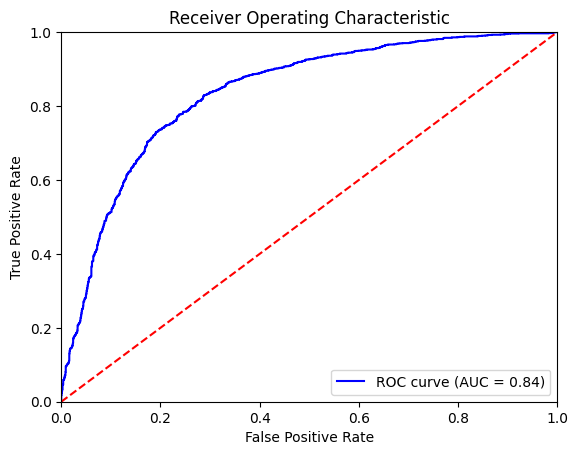

In [286]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score, confusion_matrix, matthews_corrcoef
import matplotlib.pyplot as plt

X = np.hstack((miRNA_encoded_datas, disease_encoded_datas))
y = ys.flatten()
# Scaling the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize lists to store evaluation metrics
accuracy_results, sensitivity_results, specificity_results, precision_results, mcc_results = [], [], [], [], []
y_true, y_scores = [], []
confusion_matrices = []

# Define KFold cross-validation (5-fold or 10-fold)
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # Use n_splits=10 for 10-fold CV

# Cross-validation loop
for train_index, val_index in kf.split(X):
    x_train, x_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Initialize RandomForestClassifier with class weights to handle imbalance
    clf = RandomForestClassifier(n_estimators=300, max_depth=20,min_samples_split=5,min_samples_leaf=3,random_state=42,class_weight="balanced")
    clf.fit(x_train, y_train)

    # Get predictions and probabilities for evaluation
    y_pred = clf.predict(x_val)
    y_pred_proba = clf.predict_proba(x_val)[:, 1]  # Probabilities for the positive class

    # Store true labels and predicted probabilities for ROC-AUC calculation
    y_true.extend(y_val)
    y_scores.extend(y_pred_proba)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)  # Sensitivity
    mcc = matthews_corrcoef(y_val, y_pred)
    
    # Calculate specificity using the confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    # Append each fold's metrics to results lists
    accuracy_results.append(accuracy)
    sensitivity_results.append(recall)  # Sensitivity
    specificity_results.append(specificity)
    precision_results.append(precision)
    mcc_results.append(mcc)
    
    # Calculate confusion matrix for the fold and store it
    cm = confusion_matrix(y_val, y_pred)
    confusion_matrices.append(cm)


# Calculate average metrics across all folds
avg_accuracy = sum(accuracy_results) / len(accuracy_results)
avg_sensitivity = sum(sensitivity_results) / len(sensitivity_results)
avg_specificity = sum(specificity_results) / len(specificity_results)
avg_precision = sum(precision_results) / len(precision_results)
avg_mcc = sum(mcc_results) / len(mcc_results)
roc_auc = roc_auc_score(y_true, y_scores)  # Overall ROC-AUC score

# Print confusion matrix for the final model (using last fold as representative)
final_cm = confusion_matrices[-1]
print(f"Confusion Matrix:\n{final_cm}\n")

# Display results
print(f"Average Accuracy (Acc): {avg_accuracy:.4f}")
print(f"Average Sensitivity (Sen): {avg_sensitivity:.4f}")
print(f"Average Specificity (Spe): {avg_specificity:.4f}")
print(f"Average Precision (Pre): {avg_precision:.4f}")
print(f"Average Matthews Correlation Coefficient (Mcc): {avg_mcc:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")

fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.savefig('roc_curve.png')

plt.show()


Confusion Matrix:
[[563   3]
 [ 26  28]]

Average Accuracy (Acc): 0.9381
Average Sensitivity (Sen): 0.8159
Average Specificity (Spe): 0.9498
Average Precision (Pre): 0.6099
Average Matthews Correlation Coefficient (Mcc): 0.6730
ROC-AUC Score: 0.9530


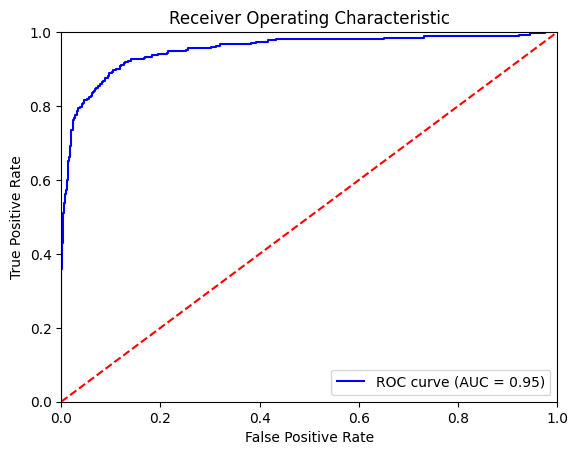

In [287]:
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score, confusion_matrix, matthews_corrcoef
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Assuming miRNA_encoded_datas, disease_encoded_datas, and label are already loaded.
X = np.hstack((miRNA_encoded_datas, disease_encoded_datas))  # Your feature matrix
y = label.flatten()  # Your target labels

# Initialize lists to store evaluation metrics
accuracy_results, sensitivity_results, specificity_results, precision_results, mcc_results = [], [], [], [], []
y_true, y_scores = [], []
confusion_matrices = []

# Scaling the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize Support Vector Machine (SVM) classifier with probability estimation
clf = SVC(random_state=42, probability=True, C=1, kernel='rbf')  # Adjust C for regularization

# Use Stratified K-Fold for cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Cross-validation loop
for train_index, val_index in cv.split(X_scaled, y):
    # Split the data into train and validation
    x_train, x_val = X_scaled[train_index], X_scaled[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Train the model
    clf.fit(x_train, y_train)

    # Get predictions and probabilities for evaluation
    y_pred = clf.predict(x_val)
    y_pred_proba = clf.predict_proba(x_val)[:, 1]  # Probabilities for the positive class

    # Thresholding
    threshold = 0.1
    y_pred_threshold = (y_pred_proba >= threshold).astype(int)

    # Store true labels and predicted probabilities for ROC-AUC calculation
    y_true.extend(y_val)
    y_scores.extend(y_pred_proba)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_val, y_pred_threshold)
    precision = precision_score(y_val, y_pred_threshold)
    recall = recall_score(y_val, y_pred_threshold)  # Sensitivity
    mcc = matthews_corrcoef(y_val, y_pred_threshold)

    # Calculate specificity using the confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_val, y_pred_threshold).ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    # Append each fold's metrics to results lists
    accuracy_results.append(accuracy)
    sensitivity_results.append(recall)  # Sensitivity
    specificity_results.append(specificity)
    precision_results.append(precision)
    mcc_results.append(mcc)

    # Calculate confusion matrix for the fold and store it
    cm = confusion_matrix(y_val, y_pred)
    confusion_matrices.append(cm)

# Calculate average metrics (mean over cross-validation)
avg_accuracy = np.mean(accuracy_results)
avg_sensitivity = np.mean(sensitivity_results)
avg_specificity = np.mean(specificity_results)
avg_precision = np.mean(precision_results)
avg_mcc = np.mean(mcc_results)

# Calculate ROC-AUC score
roc_auc = roc_auc_score(y_true, y_scores)  # Overall ROC-AUC score

# Print confusion matrix for the final model (using last fold as representative)
final_cm = confusion_matrices[-1]
print(f"Confusion Matrix:\n{final_cm}\n")

# Display results
print(f"Average Accuracy (Acc): {avg_accuracy:.4f}")
print(f"Average Sensitivity (Sen): {avg_sensitivity:.4f}")
print(f"Average Specificity (Spe): {avg_specificity:.4f}")
print(f"Average Precision (Pre): {avg_precision:.4f}")
print(f"Average Matthews Correlation Coefficient (Mcc): {avg_mcc:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc_value = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', label='ROC curve (AUC = %0.2f)' % roc_auc_value)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.savefig('roc_curve_svm.png')
plt.show()
